In [4]:
from block_bootstrap_simulation_1v import run_bootstrap_simulation_single
import pandas as pd

In [16]:

data = pd.read_csv("../data/processed/tmax2m_sp_point.csv", parse_dates=["date"])
data = data.set_index("date")

run_bootstrap_simulation_single(
    data=data,
    variable="tmax2m",
    n_simulations=1000,
    block_length=7,
    window_days=20,
    output_dir="../data/processed/bootstrap_tmax2m"
)

100%|██████████| 1000/1000 [00:00<00:00, 760526.56it/s]

✅ Completed 1000 simulations for tmax2m


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define paths
results_dir = '../data/processed/bootstrap_tmax2m/'

# Read all result files
aep_temp = pd.read_csv(f'{results_dir}aep_curve_tmax2m.csv')
sim_daily_temp = pd.read_csv(f'{results_dir}daily_simulations_tmax2m.csv')
summary_stats = pd.read_csv(f'{results_dir}summary_stats_tmax2m.csv')


In [23]:
n_sims = len([col for col in sim_daily_temp.columns if col.startswith('sim_')])

sim_dfs = []

for i in range(n_sims):
    sim_num = f'{i:04d}'
    temp_col = f'sim_{sim_num}'
    
    sim_data = pd.DataFrame({
        'temperature': sim_daily_temp[temp_col]
    })
    
    sim_data['simulation'] = i
    
    sim_dfs.append(sim_data)

sim_df_reshaped = pd.concat(sim_dfs, axis=0).reset_index(drop=True)

print(sim_df_reshaped.head())

print(sim_df_reshaped.tail())

   temperature  simulation
0    28.820220           0
1    28.012848           0
2    20.200592           0
3    21.244537           0
4    24.867340           0
        temperature  simulation
364995    28.347076         999
364996    27.511627         999
364997    28.276276         999
364998    26.618073         999
364999    24.917145         999


In [ ]:
threshold_temperature = 34

print("threshold_temp:", threshold_temperature)

sim_df_reshaped['cond_temp'] = (sim_df_reshaped['temperature'] > threshold_temperature).astype(int)

def _mark_runs(series, min_len=3):
    cond = series.astype(bool)
    runs = (cond != cond.shift()).cumsum()
    run_sizes = cond.groupby(runs).transform('size')
    return ((cond) & (run_sizes >= min_len)).astype(int)

sim_df_reshaped['event'] = sim_df_reshaped.groupby('simulation', group_keys=False)['cond_temp'].apply(_mark_runs)

sim_df_reshaped['loss'] = 100 * sim_df_reshaped['event']      # ambas a la vez

total_dias = len(sim_df_reshaped)

frac_event = sim_df_reshaped['event'].sum()        / total_dias

print("\nFracción de días con evento (respecto al total):")
print(f"Ambos (event): {frac_event:.3%}")

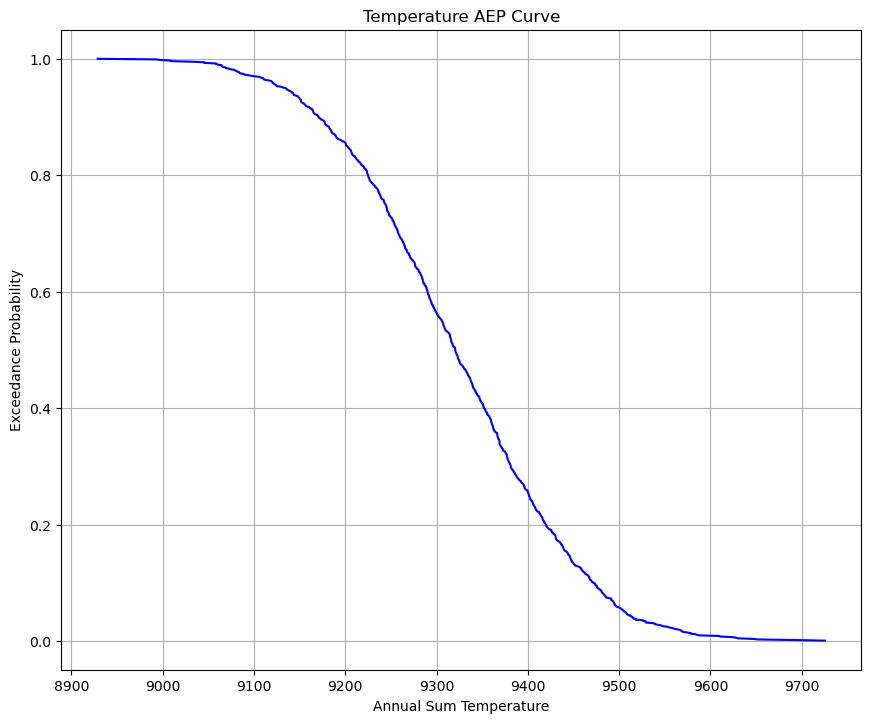

In [ ]:
fig = plt.figure(figsize=(10, 8))

ax = plt.axes([0.05, 0.05, 0.8, 0.8])

ax.plot( aep_temp['annual_sum'], aep_temp['exceedance_probability'], 'b-')
ax.set_ylabel('Exceedance Probability')
ax.set_xlabel('Annual Sum Temperature')
ax.set_title('Temperature AEP Curve')
ax.grid()
